In [76]:
from pipeline_utils import create_convnextv2_base, remove_pect_muscle, prep_convnextv2_for_gradcam,\
    predict, grad_cam_plusplus, get_org_cc_mlo_maps, remove_artifacts
import cv2
from UNet3Plus import ResNet101UNet3Plus
import torch
from torchvision.transforms import v2
import argparse


segmentor_path = r"D:\Checkpoints\last_resnet101_unet3-inbreast_mias-breast_roi-adam-no_cls_guide-no_mixup-elastic_flip-output_resized-bs8_e100.pt"
classifier_path = r"D:\Checkpoints\convnextv2_base-AdamW-up_sample-pos_smooth-mixup-ikhc-VOILUT_Flipped_pect_imgs-bs8x8-s0_e40_seed0.pt"
cc_path = r"E:\Sample over2 birads\8684388\I0000000"
mlo_path = r"E:\Sample over2 birads\8684388\I0000002"
output_cc_path = "cc_map.png" 
output_mlo_path = "mlo_map.png"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

segmentor_model = ResNet101UNet3Plus(num_classes = 2,
                   resnet_weights = None,
                   class_guided = False,
                   is_batchnorm = True,
                   output_size = (512, 512)).to(device) 
segmentor_model.load_state_dict(torch.load(segmentor_path, map_location=device))


classifier_model = create_convnextv2_base(device, classifier_path)
classifier_model = prep_convnextv2_for_gradcam(classifier_model)


segmentor_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(size = (512, 512), antialias = True),
    v2.ToDtype(torch.float32, scale = True)
    ])

resize_to_org = v2.Resize((1024, 512), antialias = True)

classifier_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.20275, 0.20275, 0.20275],
                [0.19875, 0.19875, 0.19875])])

mlo_roi, mlo_bbox, mlo_org_shape = remove_pect_muscle(mlo_path, segmentor_transform, resize_to_org, segmentor_model, device)
logits, probs, cc_mlo_img_org, cc_mlo_img, cc_bbox, cc_org_shape = predict(cc_path, mlo_roi, classifier_model, device, classifier_transform)
image_with_org_map, heatmap = grad_cam_plusplus(logits, classifier_model, cc_mlo_img_org, cc_mlo_img, device)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9892\1285607350.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentor_model.load_state_dict(torch.load(segmentor_path, ma

Loading D:\Checkpoints\convnextv2_base-AdamW-up_sample-pos_smooth-mixup-ikhc-VOILUT_Flipped_pect_imgs-bs8x8-s0_e40_seed0.pt
<All keys matched successfully>


In [77]:
def min_max_norm(a):
    a_norm = (a - a.min()) / (a.max() - a.min())
    return a_norm, a.max(), a.min()

def min_max_denorm(a_norm, a_max, a_min):
    return (a_norm * (a_max - a_min)) + a_min

def array_info(arr, name: str = ""):
    print(f"{name}\nType: {type(arr)}\nShape: {arr.shape}\ndtype: {arr.dtype}\nmin/max: {arr.min()}/{arr.max()}")

In [124]:
import numpy as np

heatmap_a = np.dstack((heatmap, np.full(heatmap.shape[:-1], 255, dtype = np.uint8)))

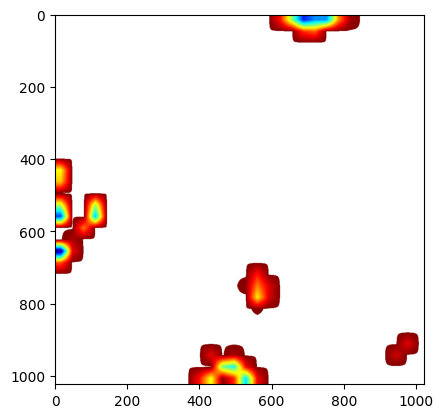

In [125]:
import matplotlib.pyplot as plt

def heatmap_transparent(heatmap, start_color = [128, 0, 0, 255], end_color = [128, 0, 0, 255]):
    """Makes the heatmap background transparent"""
    # Define the replacement range
    replacement_start = np.array(start_color[:-1] + [0])
    replacement_end = np.array(end_color[:-1] + [0])
    
    # Define color ranges for substitution
    start_color = np.array(start_color)  # Starting RGBA range
    end_color = np.array(end_color) # Ending RGBA range
    
    # Create a mask for pixels within the range
    mask = np.all((heatmap >= start_color) & (heatmap <= end_color), axis=-1)
    
    # Replace the colors for matching pixels
    heatmap[mask] = replacement_start + (heatmap[mask] - start_color)

    return heatmap

heatmap_a = heatmap_transparent(heatmap_a)
plt.imshow(heatmap_a)


In [133]:
def remove_artifacts(heatmap, cc_mlo_img, threshold = 0):
    """Removes any hot area outside the breast tissue"""
    mask = ((min_max_norm(cc_mlo_img)[0] * 255)[0] > threshold).type(torch.uint8).numpy()
    mask = cv2.dilate(mask, (5, 5), iterations = 5)[..., np.newaxis]
    return heatmap * mask

# array_info(heatmap, "heatmap")
# array_info(cc_mlo_img)

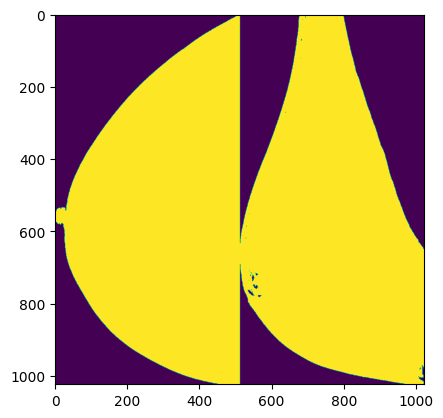

In [127]:
plt.imshow(mask * 255)

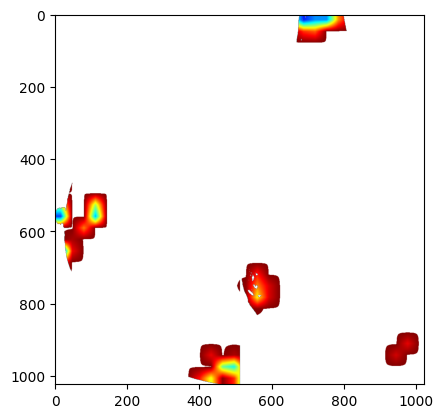

In [134]:
import matplotlib.pyplot as plt

heatmap_a = remove_artifacts(heatmap_a, cc_mlo_img)

plt.imshow(heatmap_a)


In [132]:
cc_map, mlo_map = get_org_cc_mlo_maps(heatmap_a, cc_bbox, mlo_bbox, cc_org_shape, mlo_org_shape)

cv2.imwrite(output_cc_path, cv2.cvtColor(cc_map, cv2.COLOR_RGBA2BGRA))
cv2.imwrite(output_mlo_path, cv2.cvtColor(mlo_map, cv2.COLOR_RGBA2BGRA))
cv2.imwrite("image_with_org_map.png", cv2.cvtColor(image_with_org_map, cv2.COLOR_RGBA2BGRA))
# cv2.imwrite(output_path, cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR))

print(f"Logits: {logits}, Probs: {probs}")
print(f"Ouput images saved to {output_cc_path}, {output_mlo_path}")

Logits: tensor([[ 3.6805, -2.9677]], device='cuda:0', grad_fn=<AddmmBackward0>), Probs: tensor([[0.9987, 0.0013]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Ouput images saved to cc_map.png, mlo_map.png
